# Teacher–Student Regression: Double Descent in Overparameterized MLPs

**Goal.** Empirically reproduce the double-descent curve: as we increase model capacity (width),
test error first decreases, then increases near the interpolation threshold, and decreases again in the
highly overparameterized regime.

**Setup.**
- Teacher: fixed MLP generates targets  $y = f^{\ast}(x) + \epsilon$.
- Student: MLP with varying width, trained to minimize MSE.
- We track train/test MSE as a function of number of parameters (capacity).

**Key hypothesis.**
The peak in test error appears around the point where the student transitions from underparameterized
(insufficient capacity) to interpolating the training data (near-zero training error).

In [1]:
import sys
from pathlib import Path

# ff you're in /notebooks, add repo root to sys.path
REPO_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(REPO_ROOT))

print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])

Repo root: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps
sys.path[0]: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps


In [12]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

from src.teacher_student import MLP, make_teacher_student_regression, count_params
from src.train import train_regression
from src.logging_utils import append_row_csv

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
FIG_DIR = REPO_ROOT / "reports" / "figures"
CSV_PATH = REPO_ROOT / "results" / "sweeps.csv"

SEED = 14

def seed_all(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
data = make_teacher_student_regression(n_train=512, n_test=4096, d_in=20, teacher_width=256, teacher_depth=2, noise_std=0.1, seed=SEED,device=device)

(data.x_train.shape, data.y_train.shape, data.x_test.shape)

depth = 2
act = "relu"

widths = [4, 8, 16, 32, 64, 96, 128, 192, 256, 384, 512, 768, 1024]

rows = []
for w in widths:
    seed_all(SEED)
    model = MLP(d_in=data.x_train.shape[1], width=w, depth=depth, act=act)
    p = count_params(model)

    hist, wall = train_regression(
        model,
        data.x_train, data.y_train,
        data.x_test, data.y_test,
        lr=3e-3,
        weight_decay=0.0,
        optimizer="adam",
        batch_size=128,
        steps=5000,
        log_every=250,
        device=device,
    )

    row = {
        "experiment": "01_teacher_student_double_descent",
        "seed": SEED,
        "student_depth": depth,
        "student_width": w,
        "activation": act,
        "params": p,
        "noise_std": 0.1,
        "optimizer": "adam",
        "lr": 3e-3,
        "weight_decay": 0.0,
        "steps": 5000,
        "train_mse": hist["train_mse"][-1],
        "test_mse": hist["test_mse"][-1],
        "wall_sec": wall,
    }
    rows.append(row)
    append_row_csv(CSV_PATH, row)

rows[:2], f"logged -> {CSV_PATH}"

params = np.array([r["params"] for r in rows])
train_mse = np.array([r["train_mse"] for r in rows])
test_mse  = np.array([r["test_mse"] for r in rows])

order = np.argsort(params)
params, train_mse, test_mse = params[order], train_mse[order], test_mse[order]

plt.figure(figsize=(8,5))
plt.plot(params, test_mse, marker="o", label="test MSE")
plt.plot(params, train_mse, marker="o", label="train MSE")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# parameters (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Teacher–Student Regression: Double Descent (capacity sweep)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)

FIG_DIR.mkdir(parents=True, exist_ok=True)
out = FIG_DIR / "01_double_descent_curve.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
out

([{'experiment': '01_teacher_student_double_descent',
   'seed': <module 'random' from 'c:\\Users\\jiaya\\anaconda3\\Lib\\random.py'>,
   'student_depth': 2,
   'student_width': 4,
   'activation': 'relu',
   'params': 109,
   'noise_std': 0.1,
   'optimizer': 'adam',
   'lr': 0.003,
   'weight_decay': 0.0,
   'steps': 5000,
   'train_mse': 13.827367782592773,
   'test_mse': 23.378674507141113,
   'wall_sec': 4.6496217250823975},
  {'experiment': '01_teacher_student_double_descent',
   'seed': <module 'random' from 'c:\\Users\\jiaya\\anaconda3\\Lib\\random.py'>,
   'student_depth': 2,
   'student_width': 8,
   'activation': 'relu',
   'params': 249,
   'noise_std': 0.1,
   'optimizer': 'adam',
   'lr': 0.003,
   'weight_decay': 0.0,
   'steps': 5000,
   'train_mse': 7.855951309204102,
   'test_mse': 32.77304649353027,
   'wall_sec': 4.598397493362427}],
 'logged -> c:\\Users\\jiaya\\OneDrive\\Documents\\Lund_2025\\Deep_Learning_and_AI_methods\\double-descent-overparameterized-mlps\\res

WindowsPath('c:/Users/jiaya/OneDrive/Documents/Lund_2025/Deep_Learning_and_AI_methods/double-descent-overparameterized-mlps/reports/figures/01_double_descent_curve.png')

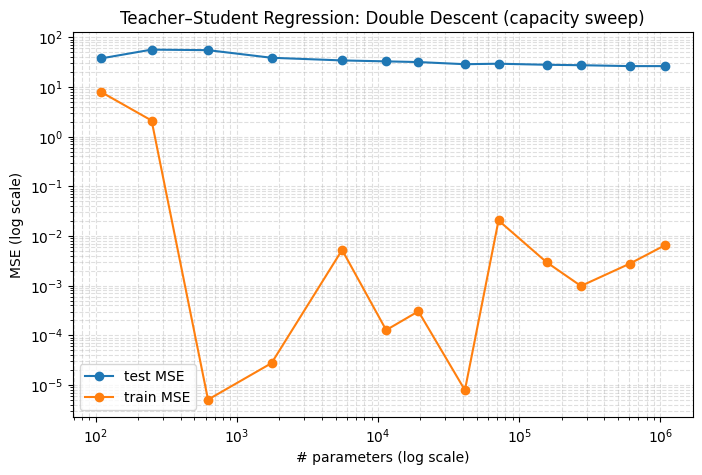

In [ ]:
# attempt 2: smaller dataset + more noise
data_2 = make_teacher_student_regression(
    n_train=256,          # smaller dataset
    n_test=4096,
    d_in=20,
    teacher_width=256,
    teacher_depth=2,
    noise_std=0.3,        # more noise
    seed=SEED,
    device=device
)

depth = 2
act = "relu"

widths = [4, 8, 16, 32, 64, 96, 128, 192, 256, 384, 512, 768, 1024]

rows = []
for w in widths:
    seed_all(SEED)
    model = MLP(d_in=data_2.x_train.shape[1], width=w, depth=depth, act=act)
    p = count_params(model)

    hist, wall = train_regression(
        model,
        data_2.x_train, data_2.y_train,
        data_2.x_test, data_2.y_test,
        lr=3e-3,
        weight_decay=0.0,
        optimizer="adam",
        batch_size=128,
        steps=8000,
        log_every=250,
        device=device,
    )

    row = {
        "experiment": "01_teacher_student_double_descent_attempt2",
        "seed": SEED,
        "student_depth": depth,
        "student_width": w,
        "activation": act,
        "params": p,
        "noise_std": 0.3,
        "optimizer": "adam",
        "lr": 3e-3,
        "weight_decay": 0.0,
        "steps": 8000,
        "train_mse": hist["train_mse"][-1],
        "test_mse": hist["test_mse"][-1],
        "wall_sec": wall,
    }
    rows.append(row)
    append_row_csv(CSV_PATH, row)

rows[:2], f"logged -> {CSV_PATH}"

params = np.array([r["params"] for r in rows])
train_mse = np.array([r["train_mse"] for r in rows])
test_mse  = np.array([r["test_mse"] for r in rows])

order = np.argsort(params)
params, train_mse, test_mse = params[order], train_mse[order], test_mse[order]

plt.figure(figsize=(8,5))
plt.plot(params, test_mse, marker="o", label="test MSE")
plt.plot(params, train_mse, marker="o", label="train MSE")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# parameters (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Teacher–Student Regression: Double Descent (attempt 2: smaller dataset + more noise)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)

FIG_DIR.mkdir(parents=True, exist_ok=True)
out = FIG_DIR / "01_double_descent_curve_attempt2.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
out

[{'experiment': '01_teacher_student_double_descent_attempt3', 'seed': 14, 'student_depth': 2, 'student_width': 2, 'activation': 'relu', 'params': 51, 'n_train': 256, 'n_test': 4096, 'd_in': 20, 'teacher_width': 256, 'teacher_depth': 2, 'noise_std': 0.3, 'target_norm': 'train_mean_std', 'optimizer': 'sgd', 'lr': 0.01, 'weight_decay': 0.0, 'batch_size': 256, 'steps': 20000, 'train_mse': 0.3293628990650177, 'test_mse': 0.6282571852207184, 'wall_sec': 12.845037698745728}, {'experiment': '01_teacher_student_double_descent_attempt3', 'seed': 14, 'student_depth': 2, 'student_width': 4, 'activation': 'relu', 'params': 109, 'n_train': 256, 'n_test': 4096, 'd_in': 20, 'teacher_width': 256, 'teacher_depth': 2, 'noise_std': 0.3, 'target_norm': 'train_mean_std', 'optimizer': 'sgd', 'lr': 0.01, 'weight_decay': 0.0, 'batch_size': 256, 'steps': 20000, 'train_mse': 0.18407505750656128, 'test_mse': 2.1811888217926025, 'wall_sec': 12.198256492614746}]
logged -> c:\Users\jiaya\OneDrive\Documents\Lund_2025

WindowsPath('c:/Users/jiaya/OneDrive/Documents/Lund_2025/Deep_Learning_and_AI_methods/double-descent-overparameterized-mlps/reports/figures/01_double_descent_attempt3.png')

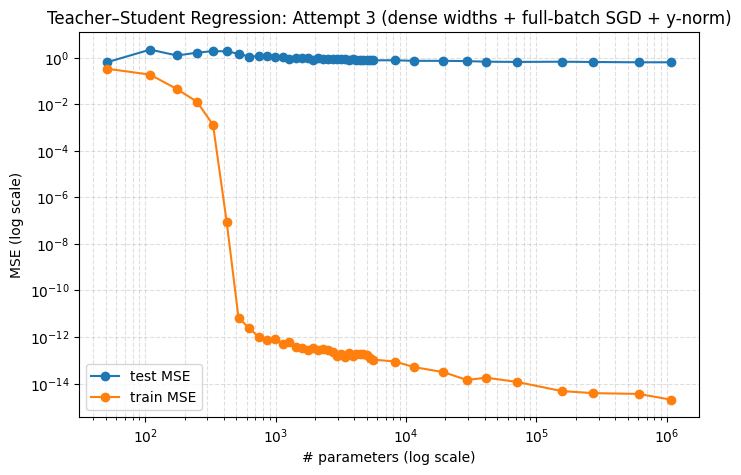

In [20]:
# Attempt 3: Dense widths + full-batch SGD + target normalization

# --- Data: smaller dataset + more noise (same as attempt 2 settings) ---
data_3 = make_teacher_student_regression(
    n_train=256,
    n_test=4096,
    d_in=20,
    teacher_width=256,
    teacher_depth=2,
    noise_std=0.3,
    seed=SEED,
    device=device
)

# --- Target normalization (important!) ---
y_mean = data_3.y_train.mean()
y_std  = data_3.y_train.std() + 1e-8
data_3.y_train = (data_3.y_train - y_mean) / y_std
data_3.y_test  = (data_3.y_test  - y_mean) / y_std

# --- Model sweep: dense near interpolation threshold ---
depth = 2
act = "relu"
widths = list(range(2, 65, 2)) + [80, 96, 128, 160, 192, 256, 384, 512, 768, 1024]

rows_3 = []
for w in widths:
    seed_all(SEED)

    model = MLP(d_in=data_3.x_train.shape[1], width=w, depth=depth, act=act)
    p = count_params(model)

    hist, wall = train_regression(
        model,
        data_3.x_train, data_3.y_train,
        data_3.x_test,  data_3.y_test,
        lr=1e-2,
        weight_decay=0.0,
        optimizer="sgd",
        batch_size=data_3.x_train.shape[0],  # full-batch
        steps=20000,
        log_every=500,
        device=device,
    )

    row = {
        "experiment": "01_teacher_student_double_descent_attempt3",
        "seed": SEED,
        "student_depth": depth,
        "student_width": w,
        "activation": act,
        "params": p,
        "n_train": 256,
        "n_test": 4096,
        "d_in": 20,
        "teacher_width": 256,
        "teacher_depth": 2,
        "noise_std": 0.3,
        "target_norm": "train_mean_std",
        "optimizer": "sgd",
        "lr": 1e-2,
        "weight_decay": 0.0,
        "batch_size": int(data_3.x_train.shape[0]),
        "steps": 20000,
        "train_mse": hist["train_mse"][-1],
        "test_mse": hist["test_mse"][-1],
        "wall_sec": wall,
    }
    rows_3.append(row)
    append_row_csv(CSV_PATH, row)

print(rows_3[:2])
print(f"logged -> {CSV_PATH}")

# --- Plot ---
params = np.array([r["params"] for r in rows_3])
train_mse = np.array([r["train_mse"] for r in rows_3])
test_mse  = np.array([r["test_mse"] for r in rows_3])

order = np.argsort(params)
params, train_mse, test_mse = params[order], train_mse[order], test_mse[order]

plt.figure(figsize=(8,5))
plt.plot(params, test_mse, marker="o", label="test MSE")
plt.plot(params, train_mse, marker="o", label="train MSE")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# parameters (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Teacher–Student Regression: Attempt 3 (dense widths + full-batch SGD + y-norm)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)

FIG_DIR.mkdir(parents=True, exist_ok=True)
out = FIG_DIR / "01_double_descent_attempt3.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
print("saved:", out)
out

[{'experiment': '01_teacher_student_double_descent_attempt4', 'seed': 14, 'student_depth': 2, 'student_width': 2, 'activation': 'relu', 'params': 51, 'n_train': 64, 'n_test': 4096, 'd_in': 20, 'teacher_width': 256, 'teacher_depth': 2, 'noise_std': 1.0, 'target_norm': 'none', 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 64, 'steps': 12000, 'train_mse': 3.824463129043579, 'test_mse': 63.622541427612305, 'wall_sec': 10.842771291732788}, {'experiment': '01_teacher_student_double_descent_attempt4', 'seed': 14, 'student_depth': 2, 'student_width': 4, 'activation': 'relu', 'params': 109, 'n_train': 64, 'n_test': 4096, 'd_in': 20, 'teacher_width': 256, 'teacher_depth': 2, 'noise_std': 1.0, 'target_norm': 'none', 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 64, 'steps': 12000, 'train_mse': 0.08044427633285522, 'test_mse': 57.30893898010254, 'wall_sec': 10.161015272140503}]
logged -> c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_

WindowsPath('c:/Users/jiaya/OneDrive/Documents/Lund_2025/Deep_Learning_and_AI_methods/double-descent-overparameterized-mlps/reports/figures/01_double_descent_attempt4.png')

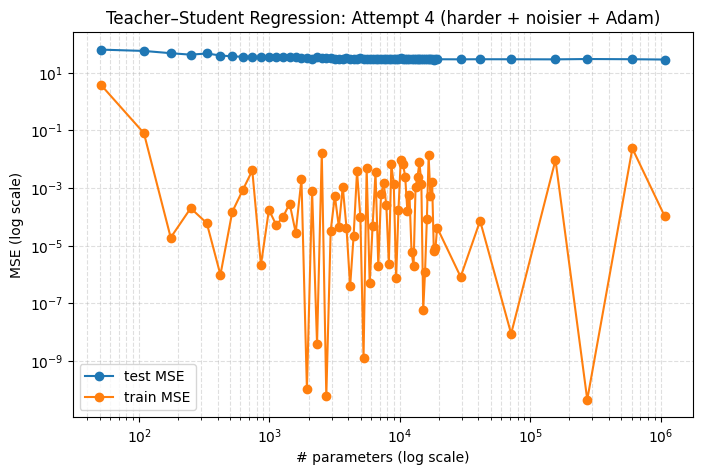

In [21]:
# Attempt 4: setup (harder + noisier + Adam + no y-norm)

# --- Make problem harder (smaller n_train + higher label noise) ---
N_TRAIN = 64
NOISE_STD = 1.0

data_4 = make_teacher_student_regression(
    n_train=N_TRAIN,
    n_test=4096,
    d_in=20,
    teacher_width=256,
    teacher_depth=2,
    noise_std=NOISE_STD,
    seed=SEED,
    device=device
)

# --- Capacity sweep: very dense near small widths, because interpolation threshold is narrow ---
depth = 2
act = "relu"
widths = list(range(2, 129, 2)) + [160, 192, 256, 384, 512, 768, 1024]

# --- Adam tends to show a clearer peak; use moderate steps (avoid over-training) ---
LR = 1e-3
STEPS = 12000
BATCH = 64  # mini-batch (not full-batch)

rows_4 = []
for w in widths:
    seed_all(SEED)

    model = MLP(d_in=data_4.x_train.shape[1], width=w, depth=depth, act=act)
    p = count_params(model)

    hist, wall = train_regression(
        model,
        data_4.x_train, data_4.y_train,
        data_4.x_test,  data_4.y_test,
        lr=LR,
        weight_decay=0.0,
        optimizer="adam",
        batch_size=min(BATCH, int(data_4.x_train.shape[0])),
        steps=STEPS,
        log_every=500,
        device=device,
    )

    row = {
        "experiment": "01_teacher_student_double_descent_attempt4",
        "seed": SEED,
        "student_depth": depth,
        "student_width": w,
        "activation": act,
        "params": p,
        "n_train": N_TRAIN,
        "n_test": 4096,
        "d_in": 20,
        "teacher_width": 256,
        "teacher_depth": 2,
        "noise_std": NOISE_STD,
        "target_norm": "none",
        "optimizer": "adam",
        "lr": LR,
        "weight_decay": 0.0,
        "batch_size": min(BATCH, int(data_4.x_train.shape[0])),
        "steps": STEPS,
        "train_mse": hist["train_mse"][-1],
        "test_mse": hist["test_mse"][-1],
        "wall_sec": wall,
    }
    rows_4.append(row)
    append_row_csv(CSV_PATH, row)

print(rows_4[:2])
print(f"logged -> {CSV_PATH}")

# --- Plot ---
params = np.array([r["params"] for r in rows_4])
train_mse = np.array([r["train_mse"] for r in rows_4])
test_mse  = np.array([r["test_mse"] for r in rows_4])

order = np.argsort(params)
params, train_mse, test_mse = params[order], train_mse[order], test_mse[order]

plt.figure(figsize=(8,5))
plt.plot(params, test_mse, marker="o", label="test MSE")
plt.plot(params, train_mse, marker="o", label="train MSE")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# parameters (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Teacher–Student Regression: Attempt 4 (harder + noisier + Adam)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)

FIG_DIR.mkdir(parents=True, exist_ok=True)
out = FIG_DIR / "01_double_descent_attempt4.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
print("saved:", out)
out

Interpolation starts at m = 260
Figure saved to: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps\reports\figures\01_attempt4a_random_features_regression.png


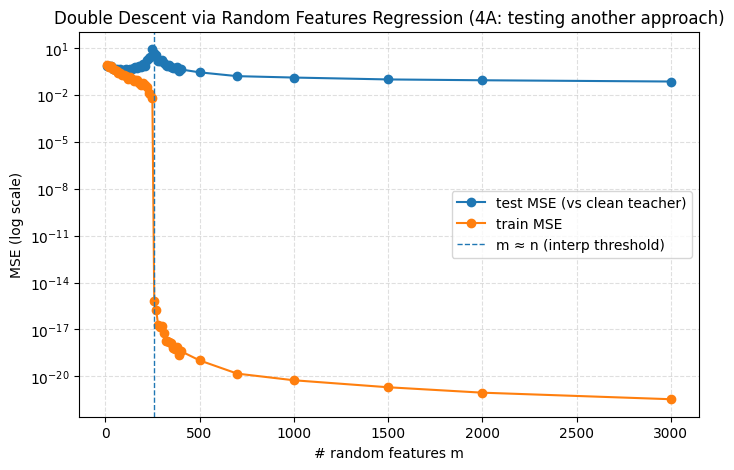

In [31]:
# Attempt 4A: Random Features Regression (clean, paper-style double descent)
rng = np.random.default_rng(SEED)

# --- DGP ---
n_train = 256
n_test  = 4096
d_in    = 50
noise_std = 0.5

Xtr = rng.standard_normal((n_train, d_in))
Xte = rng.standard_normal((n_test,  d_in))

# teacher is linear in input space (clean + stable)
w_star = rng.standard_normal(d_in) / np.sqrt(d_in)
ytr_clean = Xtr @ w_star
yte_clean = Xte @ w_star

ytr = ytr_clean + noise_std * rng.standard_normal(n_train)
yte = yte_clean  # evaluate against clean teacher

# normalize targets (optional but makes scales nice)
y_mean = ytr.mean()
y_std  = ytr.std() + 1e-8
ytr = (ytr - y_mean) / y_std
yte = (yte - y_mean) / y_std

# --- Random feature map: phi(x) = relu(Wx / sqrt(d)) ---
def relu(z): return np.maximum(z, 0.0)

# Sweep #features m (capacity)
ms = list(range(10, 401, 10)) + [500, 700, 1000, 1500, 2000, 3000]

train_mse = []
test_mse  = []

# small ridge for numerical stability; set to 0.0 if you want pure interpolation
ridge = 1e-8

for m in ms:
    W = rng.standard_normal((m, d_in)) / np.sqrt(d_in)  # fixed random first layer

    Phi_tr = relu(Xtr @ W.T)  # (n, m)
    Phi_te = relu(Xte @ W.T)

    # Solve ridge regression in feature space:
    # beta = argmin ||Phi beta - y||^2 + ridge ||beta||^2
    # Closed form: beta = (Phi^T Phi + ridge I)^(-1) Phi^T y
    A = Phi_tr.T @ Phi_tr + ridge * np.eye(m)
    b = Phi_tr.T @ ytr
    beta = np.linalg.solve(A, b)

    yhat_tr = Phi_tr @ beta
    yhat_te = Phi_te @ beta

    train_mse.append(np.mean((yhat_tr - ytr) ** 2))
    test_mse.append(np.mean((yhat_te - yte) ** 2))

# --- Plot double descent ---
plt.figure(figsize=(8,5))
plt.plot(ms, test_mse, marker="o", label="test MSE (vs clean teacher)")
plt.plot(ms, train_mse, marker="o", label="train MSE")
plt.axvline(n_train, linestyle="--", linewidth=1, label="m ≈ n (interp threshold)")
plt.yscale("log")
plt.xlabel("# random features m")
plt.ylabel("MSE (log scale)")
plt.title("Double Descent via Random Features Regression (4A: testing another approach)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

interp_idx = np.where(np.array(train_mse) < 1e-8)[0][0]
print("Interpolation starts at m =", ms[interp_idx])

FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "01_attempt4a_random_features_regression.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")

print("Figure saved to:", out_path)
plt.show()

Logged to: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps\results\sweeps.csv
Figure saved to: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps\reports\figures\01_attempt5_mlp_double_descent.png


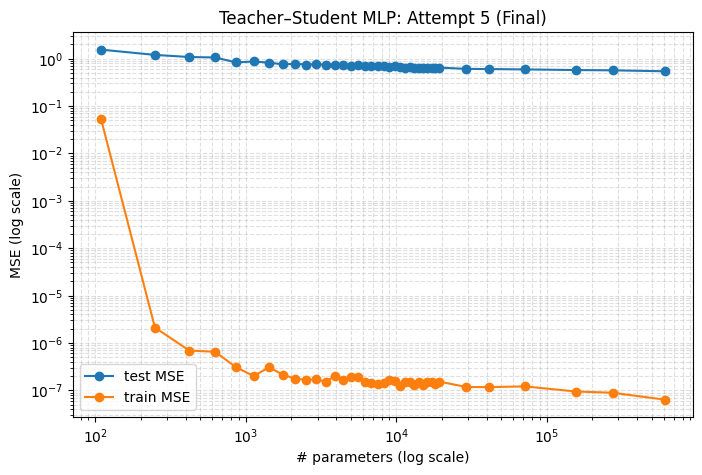

In [ ]:
# Attempt 5: Stable (hopefully) MLP Double Descent

SEED = 14
seed_all(SEED)

N_TRAIN = 128
NOISE_STD = 0.4

data_5 = make_teacher_student_regression(
    n_train=N_TRAIN,
    n_test=4096,
    d_in=20,
    teacher_width=256,
    teacher_depth=2,
    noise_std=NOISE_STD,
    seed=SEED,
    device=device
)

# Normalize targets for stability
y_mean = data_5.y_train.mean()
y_std  = data_5.y_train.std() + 1e-8
data_5.y_train = (data_5.y_train - y_mean) / y_std
data_5.y_test  = (data_5.y_test  - y_mean) / y_std

depth = 2
act = "relu"

widths = list(range(4, 129, 4)) + [160, 192, 256, 384, 512, 768]

rows_5 = []

for w in widths:
    seed_all(SEED)

    model = MLP(d_in=data_5.x_train.shape[1], width=w, depth=depth, act=act)
    p = count_params(model)

    hist, wall = train_regression(
        model,
        data_5.x_train, data_5.y_train,
        data_5.x_test,  data_5.y_test,
        lr=5e-3,
        weight_decay=1e-4,
        optimizer="sgd",
        batch_size=32,
        steps=15000,
        log_every=500,
        device=device,
    )

    row = {
        "experiment": "01_teacher_student_double_descent_attempt5",
        "seed": SEED,
        "n_train": N_TRAIN,
        "noise_std": NOISE_STD,
        "student_depth": depth,
        "student_width": w,
        "activation": act,
        "optimizer": "sgd",
        "lr": 5e-3,
        "weight_decay": 1e-4,
        "batch_size": 32,
        "steps": 15000,
        "params": p,
        "train_mse": hist["train_mse"][-1],
        "test_mse": hist["test_mse"][-1],
        "wall_sec": wall,
    }

    rows_5.append(row)
    append_row_csv(CSV_PATH, row)

print("Logged to:", CSV_PATH)

# -------- Plot --------

params = np.array([r["params"] for r in rows_5])
train_mse = np.array([r["train_mse"] for r in rows_5])
test_mse  = np.array([r["test_mse"] for r in rows_5])

order = np.argsort(params)
params, train_mse, test_mse = params[order], train_mse[order], test_mse[order]

plt.figure(figsize=(8,5))
plt.plot(params, test_mse, marker="o", label="test MSE")
plt.plot(params, train_mse, marker="o", label="train MSE")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# parameters (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Teacher–Student MLP: Attempt 5 (back to MLP)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "01_attempt5_mlp_double_descent.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")

print("Figure saved to:", out_path)
plt.show()

Logged to: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps\results\sweeps.csv
Figure saved to: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps\reports\figures\01_attempt6_mlp_dual_test.png


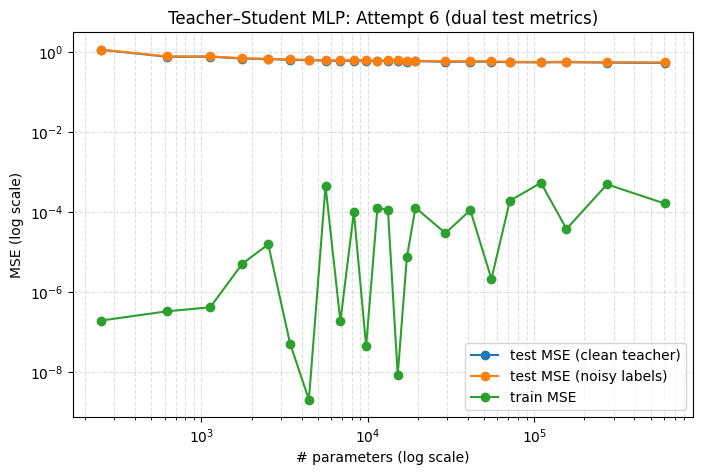

In [27]:
# Attempt 6: MLP double descent with clean-vs-noisy test metrics

import time

SEED = 14
seed_all(SEED)

# --- Data ---
N_TRAIN = 128
N_TEST  = 4096
D_IN    = 20
TEACH_W = 256
TEACH_D = 2
NOISE_STD = 0.8   # stronger noise than attempt 5

data_6 = make_teacher_student_regression(
    n_train=N_TRAIN,
    n_test=N_TEST,
    d_in=D_IN,
    teacher_width=TEACH_W,
    teacher_depth=TEACH_D,
    noise_std=NOISE_STD,
    seed=SEED,
    device=device
)

# IMPORTANT: create a *noisy* test target too (same noise level)
# (keep the clean teacher target in data_6.y_test already)
gen = torch.Generator(device="cpu")
gen.manual_seed(SEED + 999)
y_test_noisy = data_6.y_test.detach().cpu() + NOISE_STD * torch.randn(N_TEST, generator=gen)
y_test_noisy = y_test_noisy.to(device)

# Normalize targets using *training* stats (stabilizes optimization)
y_mean = data_6.y_train.mean()
y_std  = data_6.y_train.std() + 1e-8
data_6.y_train = (data_6.y_train - y_mean) / y_std
data_6.y_test  = (data_6.y_test  - y_mean) / y_std
y_test_noisy   = (y_test_noisy   - y_mean) / y_std

# --- Model/sweep ---
depth = 2          
act = "relu"
widths = list(range(8, 129, 8)) + [160, 192, 224, 256, 320, 384, 512, 768]

LR = 1e-3
STEPS = 30000
BATCH = 64
WEIGHT_DECAY = 0.0      # remove explicit regularization to allow peak

rows_6 = []

# We'll need a local MSE function that can evaluate against y_test_noisy too
@torch.no_grad()
def mse_torch(model, x, y, batch_size=2048):
    model.eval()
    n = x.shape[0]
    total = 0.0
    for i in range(0, n, batch_size):
        xb = x[i:i+batch_size]
        yb = y[i:i+batch_size]
        pred = model(xb)
        total += torch.mean((pred - yb) ** 2).item() * xb.shape[0]
    return total / n

for w in widths:
    seed_all(SEED)

    model = MLP(d_in=data_6.x_train.shape[1], width=w, depth=depth, act=act)
    p = count_params(model)

    hist, wall = train_regression(
        model,
        data_6.x_train, data_6.y_train,
        data_6.x_test,  data_6.y_test,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        optimizer="adam",
        batch_size=min(BATCH, int(data_6.x_train.shape[0])),
        steps=STEPS,
        log_every=1000,
        device=device,
    )

    # final metrics: train, test(clean), test(noisy)
    train_mse = hist["train_mse"][-1]
    test_mse_clean = hist["test_mse"][-1]
    test_mse_noisy = mse_torch(model, data_6.x_test, y_test_noisy)

    row = {
        "experiment": "01_teacher_student_double_descent_attempt6_dual_test",
        "seed": SEED,
        "n_train": N_TRAIN,
        "n_test": N_TEST,
        "d_in": D_IN,
        "teacher_width": TEACH_W,
        "teacher_depth": TEACH_D,
        "noise_std": NOISE_STD,
        "target_norm": "train_mean_std",
        "student_depth": depth,
        "student_width": w,
        "activation": act,
        "optimizer": "adam",
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "batch_size": min(BATCH, int(data_6.x_train.shape[0])),
        "steps": STEPS,
        "params": p,
        "train_mse": train_mse,
        "test_mse_clean": test_mse_clean,
        "test_mse_noisy": test_mse_noisy,
        "wall_sec": wall,
    }
    rows_6.append(row)
    append_row_csv(CSV_PATH, row)

print("Logged to:", CSV_PATH)

# --- Plot ---
params = np.array([r["params"] for r in rows_6])
train_mse = np.array([r["train_mse"] for r in rows_6])
test_clean = np.array([r["test_mse_clean"] for r in rows_6])
test_noisy = np.array([r["test_mse_noisy"] for r in rows_6])

order = np.argsort(params)
params, train_mse, test_clean, test_noisy = params[order], train_mse[order], test_clean[order], test_noisy[order]

plt.figure(figsize=(8,5))
plt.plot(params, test_clean, marker="o", label="test MSE (clean teacher)")
plt.plot(params, test_noisy, marker="o", label="test MSE (noisy labels)")
plt.plot(params, train_mse, marker="o", label="train MSE")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# parameters (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Teacher–Student MLP: Attempt 6 (dual test metrics)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "01_attempt6_mlp_dual_test.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print("Figure saved to:", out_path)
plt.show()

Logged to: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps\results\sweeps.csv
Figure saved to: c:\Users\jiaya\OneDrive\Documents\Lund_2025\Deep_Learning_and_AI_methods\double-descent-overparameterized-mlps\reports\figures\01_attempt6a_mlp_fullbatch_earlystop.png


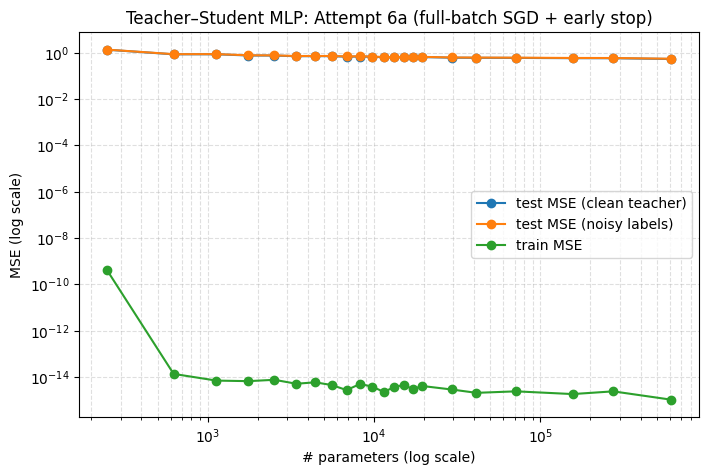

In [28]:
# Attempt 6a: Stable dual-metric MLP (full-batch SGD + early stop)

seed_all(SEED)

N_TRAIN = 128
N_TEST  = 4096
D_IN    = 20
NOISE_STD = 0.8

data_6a = make_teacher_student_regression(
    n_train=N_TRAIN,
    n_test=N_TEST,
    d_in=D_IN,
    teacher_width=256,
    teacher_depth=2,
    noise_std=NOISE_STD,
    seed=SEED,
    device=device
)

# make noisy test labels (same noise level)
gen = torch.Generator(device="cpu")
gen.manual_seed(SEED + 999)
y_test_noisy = data_6a.y_test.detach().cpu() + NOISE_STD * torch.randn(N_TEST, generator=gen)
y_test_noisy = y_test_noisy.to(device)

# normalize using train stats
y_mean = data_6a.y_train.mean()
y_std  = data_6a.y_train.std() + 1e-8
data_6a.y_train = (data_6a.y_train - y_mean) / y_std
data_6a.y_test  = (data_6a.y_test  - y_mean) / y_std
y_test_noisy    = (y_test_noisy    - y_mean) / y_std

depth = 2
act = "relu"

widths = list(range(8, 129, 8)) + [160, 192, 256, 384, 512, 768]

LR = 5e-2                 # full-batch SGD can take larger LR
MAX_STEPS = 50000
LOG_EVERY = 2000
TRAIN_TARGET = 1e-6       # early stop when interpolating

@torch.no_grad()
def mse_torch(model, x, y, batch_size=2048):
    model.eval()
    n = x.shape[0]
    total = 0.0
    for i in range(0, n, batch_size):
        xb = x[i:i+batch_size]
        yb = y[i:i+batch_size]
        pred = model(xb)
        total += torch.mean((pred - yb) ** 2).item() * xb.shape[0]
    return total / n

def train_fullbatch_sgd_earlystop(model, xtr, ytr, xte, yte, lr, max_steps):
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss_fn = torch.nn.MSELoss()

    hist = {"step": [], "train_mse": [], "test_mse_clean": []}
    for step in range(1, max_steps + 1):
        model.train()
        pred = model(xtr)
        loss = loss_fn(pred, ytr)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if step % LOG_EVERY == 0 or step == 1:
            tr = mse_torch(model, xtr, ytr)
            te = mse_torch(model, xte, yte)
            hist["step"].append(step)
            hist["train_mse"].append(tr)
            hist["test_mse_clean"].append(te)

            if tr < TRAIN_TARGET:
                break
    return hist

rows_6a = []
for w in widths:
    seed_all(SEED)
    model = MLP(d_in=data_6a.x_train.shape[1], width=w, depth=depth, act=act).to(device)
    p = count_params(model)

    t0 = time.time()
    hist = train_fullbatch_sgd_earlystop(
        model, data_6a.x_train, data_6a.y_train, data_6a.x_test, data_6a.y_test,
        lr=LR, max_steps=MAX_STEPS
    )
    wall = time.time() - t0

    train_mse = mse_torch(model, data_6a.x_train, data_6a.y_train)
    test_clean = mse_torch(model, data_6a.x_test, data_6a.y_test)
    test_noisy = mse_torch(model, data_6a.x_test, y_test_noisy)

    row = {
        "experiment": "01_teacher_student_double_descent_attempt6a_fullbatch_earlystop",
        "seed": SEED,
        "n_train": N_TRAIN,
        "noise_std": NOISE_STD,
        "student_depth": depth,
        "student_width": w,
        "activation": act,
        "optimizer": "sgd_fullbatch_momentum",
        "lr": LR,
        "weight_decay": 0.0,
        "batch_size": N_TRAIN,
        "steps": hist["step"][-1],
        "params": p,
        "train_mse": train_mse,
        "test_mse_clean": test_clean,
        "test_mse_noisy": test_noisy,
        "wall_sec": wall,
    }
    rows_6a.append(row)
    append_row_csv(CSV_PATH, row)

print("Logged to:", CSV_PATH)

# Plot
params = np.array([r["params"] for r in rows_6a])
train_mse = np.array([r["train_mse"] for r in rows_6a])
test_clean = np.array([r["test_mse_clean"] for r in rows_6a])
test_noisy = np.array([r["test_mse_noisy"] for r in rows_6a])

order = np.argsort(params)
params, train_mse, test_clean, test_noisy = params[order], train_mse[order], test_clean[order], test_noisy[order]

plt.figure(figsize=(8,5))
plt.plot(params, test_clean, marker="o", label="test MSE (clean teacher)")
plt.plot(params, test_noisy, marker="o", label="test MSE (noisy labels)")
plt.plot(params, train_mse, marker="o", label="train MSE")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# parameters (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Teacher–Student MLP: Attempt 6a (full-batch SGD + early stop)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

out_path = FIG_DIR / "01_attempt6a_mlp_fullbatch_earlystop.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print("Figure saved to:", out_path)
plt.show()

In [ ]:
# Attempt 7 (MLP): Frozen first-layer 2-layer ReLU MLP
import torch.nn as nn
from src.logging_utils import append_row_csv

seed_all(SEED)

# -------------------------
# Data: teacher is linear + noise (clean and stable)
# -------------------------
N_TRAIN = 256
N_TEST  = 4096
D_IN    = 50
NOISE_STD = 0.5

g = torch.Generator(device="cpu")
g.manual_seed(SEED)

Xtr = torch.randn(N_TRAIN, D_IN, generator=g).to(device)
Xte = torch.randn(N_TEST,  D_IN, generator=g).to(device)

w_star = (torch.randn(D_IN, generator=g) / np.sqrt(D_IN)).to(device)
ytr_clean = Xtr @ w_star
yte_clean = Xte @ w_star

ytr = ytr_clean + NOISE_STD * torch.randn(N_TRAIN, generator=g).to(device)
yte = yte_clean  # evaluate vs clean teacher

# normalize targets (helps numerical stability)
y_mean = ytr.mean()
y_std  = ytr.std() + 1e-8
ytr = (ytr - y_mean) / y_std
yte = (yte - y_mean) / y_std

# -------------------------
# Model: 2-layer ReLU MLP, freeze first layer
# -------------------------
class FrozenTwoLayerReLU(nn.Module):
    def __init__(self, d_in: int, width: int):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

        # initialize first layer randomly and freeze it
        nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0/np.sqrt(d_in))
        for p in self.fc1.parameters():
            p.requires_grad = False

        # init readout small
        nn.init.zeros_(self.fc2.weight)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2(h).squeeze(-1)

def count_params_trainable(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def mse(model, x, y, batch_size=2048):
    model.eval()
    n = x.shape[0]
    total = 0.0
    for i in range(0, n, batch_size):
        xb = x[i:i+batch_size]
        yb = y[i:i+batch_size]
        pred = model(xb)
        total += torch.mean((pred - yb) ** 2).item() * xb.shape[0]
    return total / n

# -------------------------
# Sweep widths (dense around n_train)
# -------------------------
widths = list(range(10, 401, 10)) + [500, 700, 1000, 1500, 2000, 3000]

LR = 5e-2
STEPS = 20000
WEIGHT_DECAY = 0.0   # keep 0 for classic interpolation spike

rows_7 = []
t0_all = time.time()

for w in widths:
    seed_all(SEED)
    model = FrozenTwoLayerReLU(D_IN, w).to(device)
    opt = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.MSELoss()

    t0 = time.time()
    for step in range(1, STEPS+1):
        model.train()
        pred = model(Xtr)
        loss = loss_fn(pred, ytr)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    wall = time.time() - t0

    tr = mse(model, Xtr, ytr)
    te = mse(model, Xte, yte)

    # capacity: total params and trainable params
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = count_params_trainable(model)

    row = {
        "experiment": "01_attempt7_frozen_mlp_readout_sgd",
        "seed": SEED,
        "n_train": N_TRAIN,
        "n_test": N_TEST,
        "d_in": D_IN,
        "noise_std": NOISE_STD,
        "mlp_type": "2layer_relu_frozen_first",
        "width": w,
        "optimizer": "sgd",
        "lr": LR,
        "momentum": 0.9,
        "weight_decay": WEIGHT_DECAY,
        "steps": STEPS,
        "params_total": total_params,
        "params_trainable": trainable_params,
        "train_mse": tr,
        "test_mse_clean": te,
        "wall_sec": wall,
    }
    rows_7.append(row)
    append_row_csv(CSV_PATH, row)

print("Logged to:", CSV_PATH, " | total wall:", round(time.time()-t0_all, 1), "sec")

# -------------------------
# Plot + Save (IMPORTANT: save BEFORE show)
# -------------------------
m_cap = np.array([r["width"] for r in rows_7])  # "capacity" is width here
train_mse = np.array([r["train_mse"] for r in rows_7])
test_mse  = np.array([r["test_mse_clean"] for r in rows_7])

order = np.argsort(m_cap)
m_cap, train_mse, test_mse = m_cap[order], train_mse[order], test_mse[order]

fig = plt.figure(figsize=(9,5))
plt.plot(m_cap, test_mse, marker="o", label="test MSE (vs clean teacher)")
plt.plot(m_cap, train_mse, marker="o", label="train MSE")
plt.axvline(N_TRAIN, linestyle="--", linewidth=1, label="width ≈ n_train")
plt.yscale("log")
plt.xlabel("hidden width m")
plt.ylabel("MSE (log scale)")
plt.title("Attempt 7: Frozen-first-layer 2-layer ReLU MLP (train readout only)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "01_attempt7_frozen_mlp_double_descent.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print("Figure saved to:", out_path)
plt.show()